# COGS 108 - Final Project (change this to your project's title)

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [  ] NO - keep private

# Overview

*Fill in your overview here*

# Names

- Ant Man
- Hulk
- Iron Man
- Thor
- Wasp

<a id='research_question'></a>
# Research Question

*Fill in your research question here*

<a id='background'></a>

## Background & Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name:
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import os
from pathlib import Path

# converting city to county
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm # progress bar for .apply()

# for choropleth
import plotly.express as px

# used for choropleth
from urllib.request import urlopen
import json

# filter extra noise from warnings
import warnings
warnings.filterwarnings('ignore')

# Statmodels & patsy
import patsy
from scipy import stats
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats import boxcox
from scipy.stats import powerlognorm
# Make plots just slightly bigger for displaying well in notebook
plt.rcParams['figure.figsize'] = (10, 5)

# Displaying figures as image
from IPython.display import Image

# used to convert state/county to fips
import addfips

%config InlineBackend.figure_format ='retina'

In [2]:
#import housing dataset
housing_df = pd.read_csv("datasets/cleaned/NewHousingPrices2017-2021.csv")
housing_df.head()

,County & State,FIPS,2017,2018,2019,2020,2021
0,"Autauga County, Alabama",1001,145203,144361,153716,160972,166318
1,"Baldwin County, Alabama",1003,185313,205764,209494,232730,243643
2,"Barbour County, Alabama",1005,97533,91965,100423,94615,99052
3,"Bibb County, Alabama",1007,116052,110683,101799,97807,102324
4,"Blount County, Alabama",1009,135375,128203,131548,134696,140916


In [3]:
#import disaster dataset
disaster_type_df = pd.read_csv('datasets/DisasterDeclarationsSummaries.csv')
disaster_type_df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,...,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-7-MA,7,MA,DR,1953-06-11T00:00:00.000Z,1953,Tornado,TORNADO,0,1,...,1953-06-11T00:00:00.000Z,1956-06-01T00:00:00.000Z,25,0,0,Statewide,53009,9ef08cfe2ef1a86b8e6a3ec802cafc37c223edf8,2021-07-13T23:01:19.145Z,60c3b7a9a0ee349d71025720
1,DR-6-MI,6,MI,DR,1953-06-09T00:00:00.000Z,1953,Tornado,TORNADO,0,1,...,1953-06-09T00:00:00.000Z,1956-03-30T00:00:00.000Z,26,0,0,Statewide,53007,fd3377e42a13e063a569a9b6fc25872dbeeaf099,2021-07-13T23:01:19.145Z,60c3b7a9a0ee349d71025766
2,DR-2-TX,2,TX,DR,1953-05-15T00:00:00.000Z,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,...,1953-05-15T00:00:00.000Z,1958-01-01T00:00:00.000Z,48,0,0,Statewide,53003,c879557e78d059e6847e7688388c339d10f51979,2021-07-13T23:01:19.145Z,60c3b7a9a0ee349d71025783
3,DR-4-MI,4,MI,DR,1953-06-02T00:00:00.000Z,1953,Tornado,TORNADO,0,1,...,1953-06-02T00:00:00.000Z,1956-02-01T00:00:00.000Z,26,0,0,Statewide,53004,87a0c1dd5da249767f545e0c0a43f917e4e9ca83,2021-07-13T23:01:19.145Z,60c3b7a9a0ee349d7102577a
4,DR-1-GA,1,GA,DR,1953-05-02T00:00:00.000Z,1953,Tornado,TORNADO,0,1,...,1953-05-02T00:00:00.000Z,1954-06-01T00:00:00.000Z,13,0,0,Statewide,53013,bb121323c9c29d3bef0c9a3f134bfd8b5ecff148,2021-07-13T23:01:19.144Z,60c3b7a9a0ee349d71025780


# Data Cleaning #11 (Disaster Frequency + Housing Prices)

Describe your data cleaning steps here.

In [4]:
#Calculates mean of quarters for each year of housing price through 2017-2021
housing_df['Average_HP'] = housing_df.iloc[:,4:].mean(axis=1)
new_cols = ['County & State','FIPS','Average_HP']
housing_df = housing_df.reindex(columns=new_cols)

#Add the leading zeros back in to FIPS
housing_df['FIPS'] = housing_df['FIPS'].apply(lambda x: str(x))
housing_df['FIPS'] = housing_df['FIPS'].apply(lambda x: x.zfill(5))

#make the name lower case to match other dataset
housing_df = housing_df.rename(columns={'FIPS' : 'fips'})
housing_df.head()

,County & State,fips,Average_HP
0,"Autauga County, Alabama",01001,160335.333333
1,"Baldwin County, Alabama",01003,228622.333333
2,"Barbour County, Alabama",01005,98030.000000
3,"Bibb County, Alabama",01007,100643.333333
4,"Blount County, Alabama",01009,135720.000000


In [5]:
def standardize_county(str_in):
    try:
        if '(County)' in str_in:
            output = str_in.replace('(County)','')
        elif '(Borough)' in str_in:
            output = str_in.replace('(Borough)','')
        elif '(Census Subarea)'in str_in:
            output = str_in.replace('(Census Subarea)','')
        elif '(Parish)'in str_in:
            output = str_in.replace('(Parish)','')
        else:
            output = None
    except: 
        output = None

    return output


def standardize_year(str_in):
    try:
        output = str_in.split('T')[0]
        output = pd.to_datetime(str_in).year
    except:
        output = None
        
    return output

In [6]:
disaster_type_df = pd.read_csv('datasets/DisasterDeclarationsSummaries.csv')

# select a subset of the columns
wanted_columns = ['state', 'declarationDate','incidentType','declarationTitle','designatedArea']

# rename the columns
disaster_type_df = disaster_type_df[wanted_columns].rename(columns={"declarationDate":"year", "designatedArea": "county", "incidentType":"disaster_type", "declarationTitle":"disaster_declaration"})

# Set "Statewide" to None and strip "(County)" from all counties
disaster_type_df['county'] = disaster_type_df['county'].apply(standardize_county)

# filter dataset to only include non-null 
disaster_type_df = disaster_type_df[~disaster_type_df['county'].isnull()]

# strip year column to only include year
disaster_type_df['year'] = disaster_type_df['year'].apply(standardize_year)

# sort by year
disaster_type_df = disaster_type_df.sort_values('year').reset_index(drop = True)

# check for no NaNs
assert(disaster_type_df.isna().sum().sum() == 0)

disaster_type_df.head()

,state,year,disaster_type,disaster_declaration,county
0,IN,1959,Flood,FLOOD,Clay
1,WA,1964,Flood,HEAVY RAINS & FLOODING,Wahkiakum
2,WA,1964,Flood,HEAVY RAINS & FLOODING,Skamania
3,WA,1964,Flood,HEAVY RAINS & FLOODING,Pierce
4,WA,1964,Flood,HEAVY RAINS & FLOODING,Pacific


In [7]:
#a dictinary for translating state abbrevs to the state whole name
state_abv = {'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AZ': 'Arizona','CA': 'California','CO': 'Colorado',
             'CT': 'Connecticut','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','HI': 'Hawaii','IA': 'Iowa',
             'ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana',
             'MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota',
             'MO': 'Missouri','MS': 'Mississippi','MT': 'Montana','NC': 'North Carolina','ND': 'North Dakota',
             'NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada',
             'NY': 'New York','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania',
            'RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee',
             'TX': 'Texas','UT': 'Utah','VA': 'Virginia','VT': 'Vermont','WA': 'Washington',
             'WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'
                    }
#setting the state name from abv
disaster_type_df['state'] = disaster_type_df['state'].map(state_abv)

#we want to remove man made disasters from the dataset
values = ['Biological', 'Human Cause', 'Fishing Losses', 'Terrorist', 'Other','Dam/Levee Break', 'Toxic Substances']
disaster_type_df = disaster_type_df[~(disaster_type_df['disaster_type'].isin(values))]
disaster_type_df['disaster_type'].unique()

#we only want the years after 2017 to match our housing price data
dfrq_df = disaster_type_df[disaster_type_df['year'] >= 2017].reset_index(drop=True)

In [8]:
#Here we find and add all the FIPS to the disaster frequency dataset
af = addfips.AddFIPS()
def find_fips(x):
    county = x['county'].strip()
    state = x['state'].strip()
    fips = af.get_county_fips(county,state=state)
    return str(fips)
tqdm.pandas()

dfrq_df['fips'] = dfrq_df.progress_apply(find_fips,axis=1)

dfrq_df.head()

100%|█████████████████████████████████████████████████████████████| 7584/7584 [00:00<00:00, 64391.25it/s]


,state,year,disaster_type,disaster_declaration,county,fips
0,Georgia,2017,Hurricane,HURRICANE IRMA,Laurens,13175
1,Georgia,2017,Hurricane,HURRICANE IRMA,Long,13183
2,Georgia,2017,Hurricane,HURRICANE IRMA,Oconee,13219
3,Georgia,2017,Hurricane,HURRICANE IRMA,Oglethorpe,13221
4,Georgia,2017,Hurricane,HURRICANE IRMA,Peach,13225


In [9]:
#instead of unique description for each disaster we want a mean for each county over the 5 years, 
#and add the total disasters per county.
df_dcount = dfrq_df[['fips']].value_counts().to_frame()
df_dcount = df_dcount.rename(columns={0 : 'disaster_count'})
df_dcount['disaster_count']= df_dcount['disaster_count']/5
df_dcount['disaster_count'] = df_dcount['disaster_count'].astype(str)

df_dcount.head()

,disaster_count
fips,
None,9.0
22007,4.0
22101,3.8
22045,3.6
22113,3.6


In [10]:
def standardize_long(location):
    try:
        output = location.longitude
    except:
        output = None
    return output
def standardize_lat(location):
    try:
        output = location.latitude
    except:
        output = None
    return output


In [11]:
# WARNING THIS NEXT CELL WILL TAKE A LONG TIME TO RENDER

In [12]:
dfrq_df['county_state'] = dfrq_df['county']+", " +dfrq_df['state']
geolocator = Nominatim(user_agent='find_long_lat')
geocode = RateLimiter(geolocator.geocode,min_delay_seconds=1)
tqdm.pandas()
try:
    dfrq_df['geocode'] = dfrq_df['county_state'].progress_apply(geocode)
except:
    pass

  0%|                                                                 | 4/7584 [00:02<1:17:13,  1.64it/s]


In [13]:
#The previous step of getting the lat and lon of each FIPS takes a long time, so save time by just loading the dataset
#that we have already made by running this process!
dfrq_df = pd.read_csv('datasets/disaster_freq_bubblemap.csv', encoding = 'latin1', index_col = 0)
dfrq_df.head()

,state,year,disaster_type,disaster_declaration,county,fips,county_state,geocode,long,lat
0,Georgia,2017,Hurricane,HURRICANE IRMA,Laurens County,13175,"Laurens County, Georgia","Laurens County, Georgia, United States",-82.938894,32.423997
1,Georgia,2017,Hurricane,HURRICANE IRMA,Long County,13183,"Long County, Georgia","Long County, Georgia, 31316, United States",-81.753725,31.770490
2,Georgia,2017,Hurricane,HURRICANE IRMA,Oconee County,13219,"Oconee County, Georgia","Oconee County, Georgia, United States",-83.427592,33.829579
3,Georgia,2017,Hurricane,HURRICANE IRMA,Oglethorpe County,13221,"Oglethorpe County, Georgia","Oglethorpe County, Georgia, United States",-83.104938,33.870268
4,Georgia,2017,Hurricane,HURRICANE IRMA,Peach County,13225,"Peach County, Georgia","Peach County, Georgia, United States",-83.835073,32.554346


In [17]:
#Need to typecast the fips to string in housing data
housing_df['fips'] = housing_df['fips'].astype(str)
#Merging the housing price data with the disaster count!
merged_df =  pd.merge(df_dcount,housing_df,  on ='fips',how='right')
merged_df = merged_df[~merged_df.isnull().any(axis=1)]
merged_df.head()

,fips,disaster_count,County & State,Average_HP
0,01001,1.0,"Autauga County, Alabama",160335.333333
1,01003,1.2,"Baldwin County, Alabama",228622.333333
2,01005,1.2,"Barbour County, Alabama",98030.000000
3,01007,0.8,"Bibb County, Alabama",100643.333333
4,01009,1.0,"Blount County, Alabama",135720.000000


# Data Analysis & Results

Include cells that describe the steps in your data analysis.

In [18]:
import plotly.graph_objects as go

import pandas as pd

In [ ]:
#Now that we have all the lat and lon locations for every disaster location lets plot the data!
#We can see the disasters per year across the country, and what a type of disaster.
bm = pd.read_csv('datasets/disaster_freq_bubblemap.csv')
fig = px.scatter_geo(bm,lat='lat',lon='long',hover_name='county_state',animation_frame='year',
                     projection='albers usa',hover_data=['disaster_type'],color='disaster_type')
fig.show()

In [ ]:
Image(filename='images/bubblemap.gif')

In [ ]:
#Mapping out the disaster count on a choropleth
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
fig = px.choropleth(merged_df, geojson=counties,locations='fips', color='disaster_count',
                           color_continuous_scale="reds",
                           range_color=(6, 0),
                           scope="usa",
                           labels={'2021':'Housing Price'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("images/disaster_choropleth.png")
Image(filename='images/disaster_choropleth.png') 

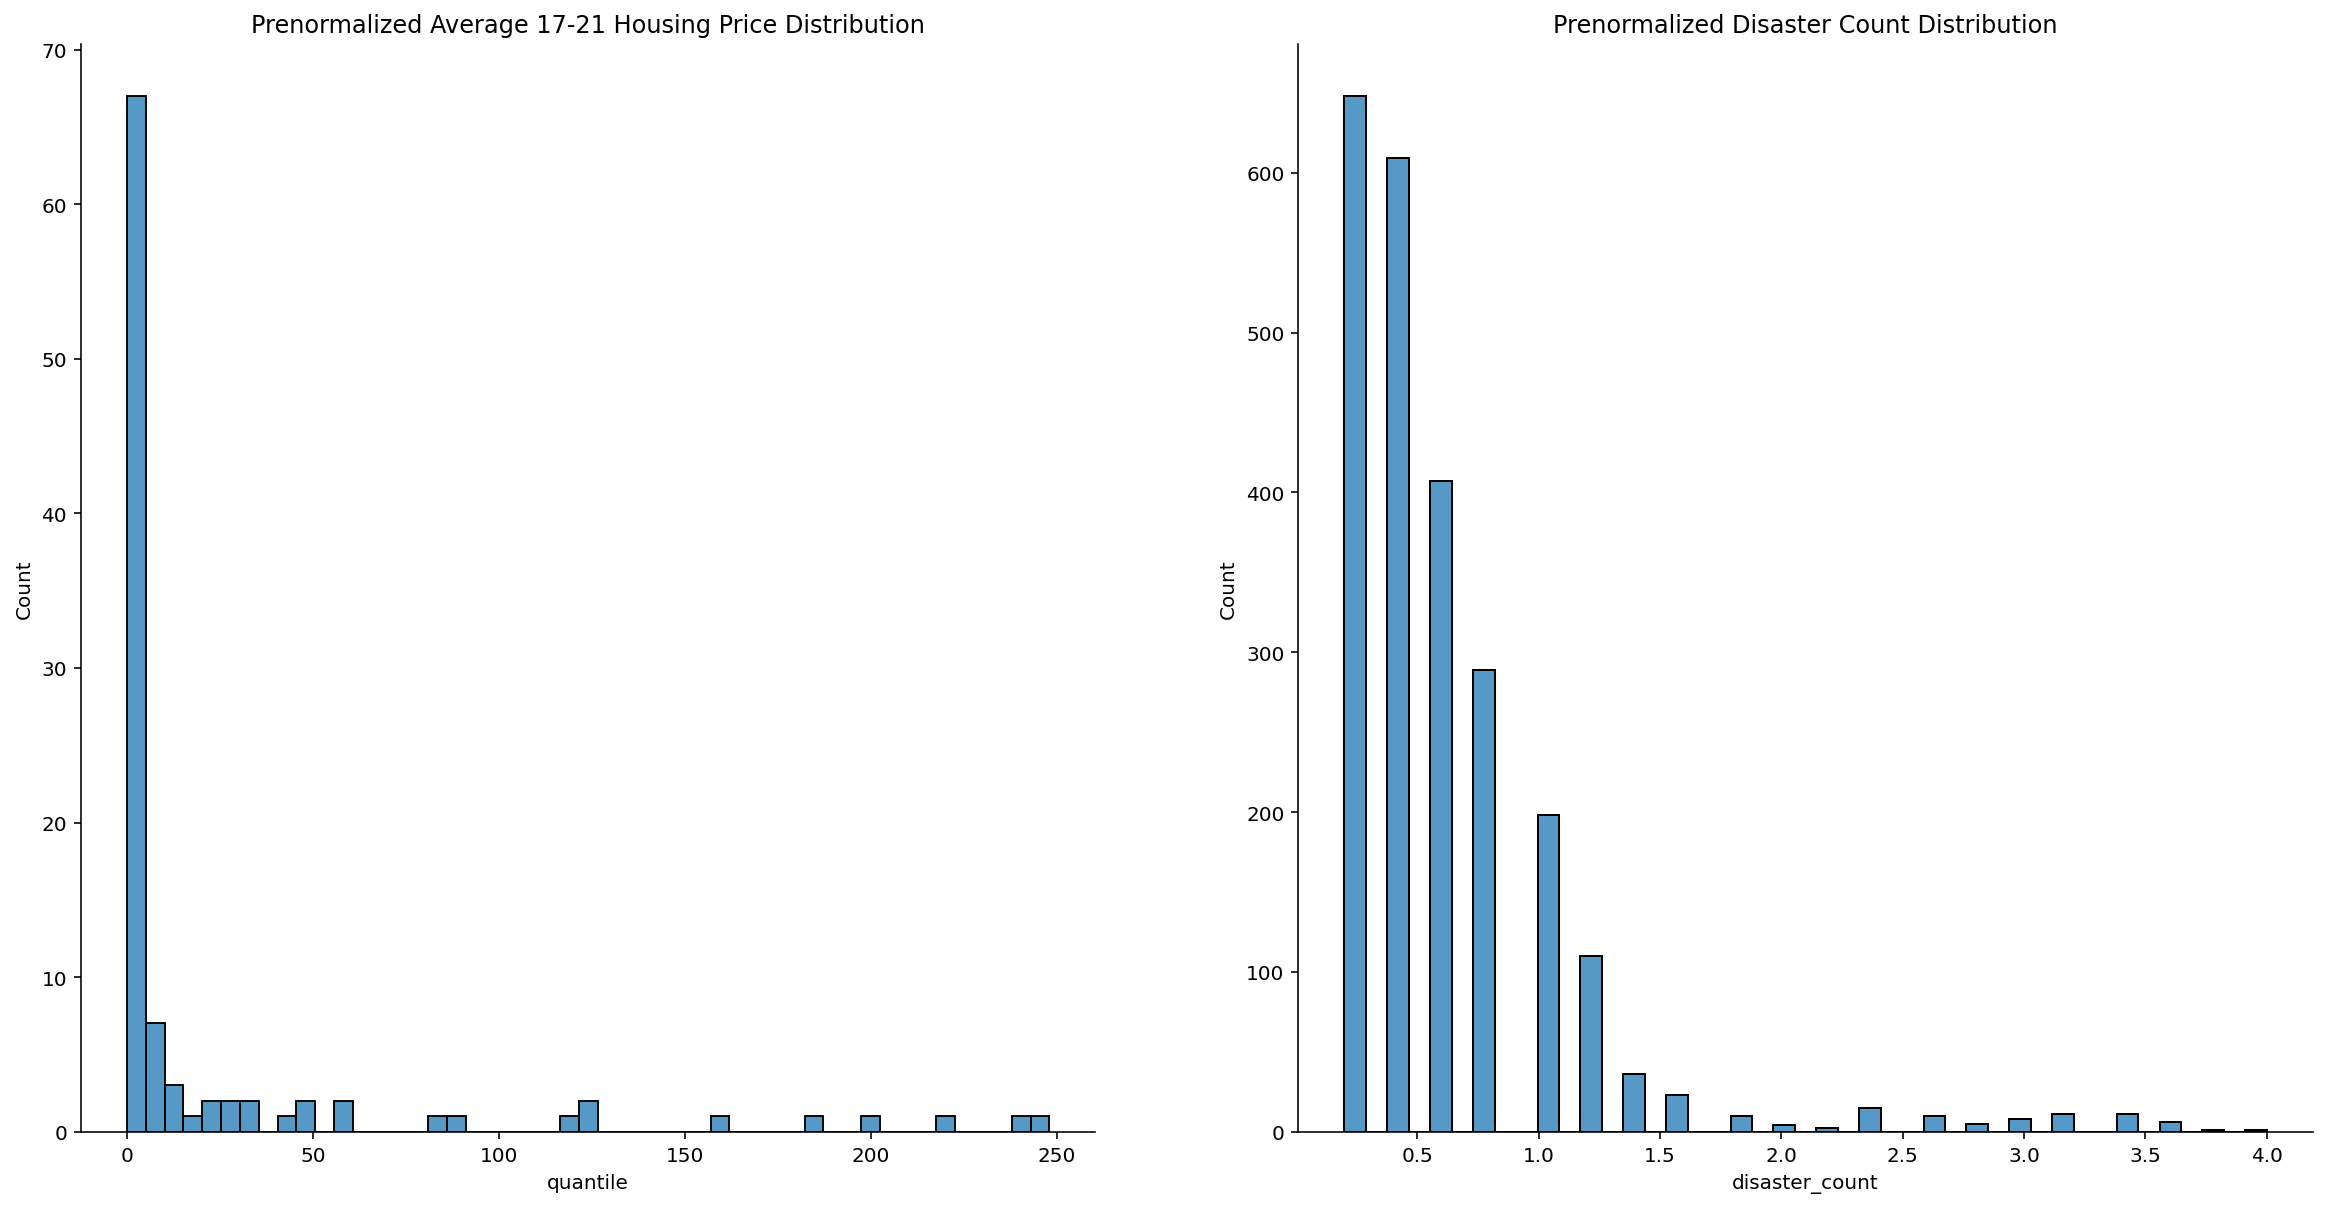

In [19]:
#Prenomralized distributions of the housing prices and disaster count/
merged_df['disaster_count'] = merged_df['disaster_count'].astype(float)
merged_df['disaster_count'] = merged_df['disaster_count'].sort_values(ascending=False)


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

#Quantized housingprice so it shows better on a barplot
merged_df['quantile'] = pd.cut(merged_df['Average_HP'],100)

sns.histplot(x=merged_df['disaster_count'], ax = ax2, data = merged_df['disaster_count'])

sns.histplot(x=merged_df['quantile'].value_counts(), ax = ax1, data = merged_df)

ax1.set_title('Prenormalized Average 17-21 Housing Price Distribution')
ax2.set_title('Prenormalized Disaster Count Distribution')

sns.despine()
plt.show()

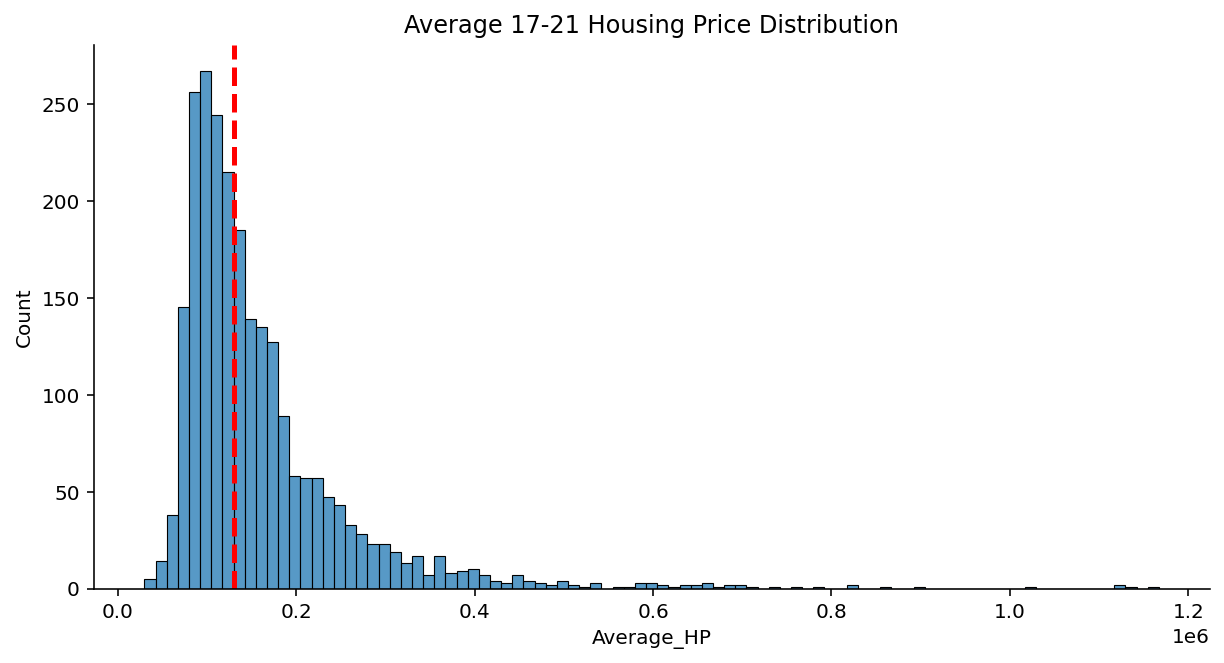

In [20]:
#A closer look at average housing price
sns.histplot(x='Average_HP', data = merged_df).set_title('Average 17-21 Housing Price Distribution')
plt.axvline(x=merged_df['Average_HP'].median(),
            color='red', ls='--', lw=2.5)
sns.despine()

In [ ]:
#A look at a chorpleth of average housing prices 
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
fig = px.choropleth(merged_df, geojson=counties,locations='fips', color='Average_HP',
                           color_continuous_scale="ylorrd",
                           range_color=(50000, 300000),
                           scope="usa",
                           labels={'2021':'Housing Price'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("images/Average_HP_choropleth.png")
Image(filename='images/Average_HP_choropleth.png') 

In [64]:
#Lets normalize the data for average housing price and for the disaster count
fitted_data, fitted_lambda = boxcox(merged_df['Average_HP'])
merged_df['Average_HP_boxcox'] = fitted_data

fitted_data2,fitted_lambda2 = boxcox(merged_df['disaster_count']+0.1)
merged_df['disaster_count_boxcox'] = fitted_data2


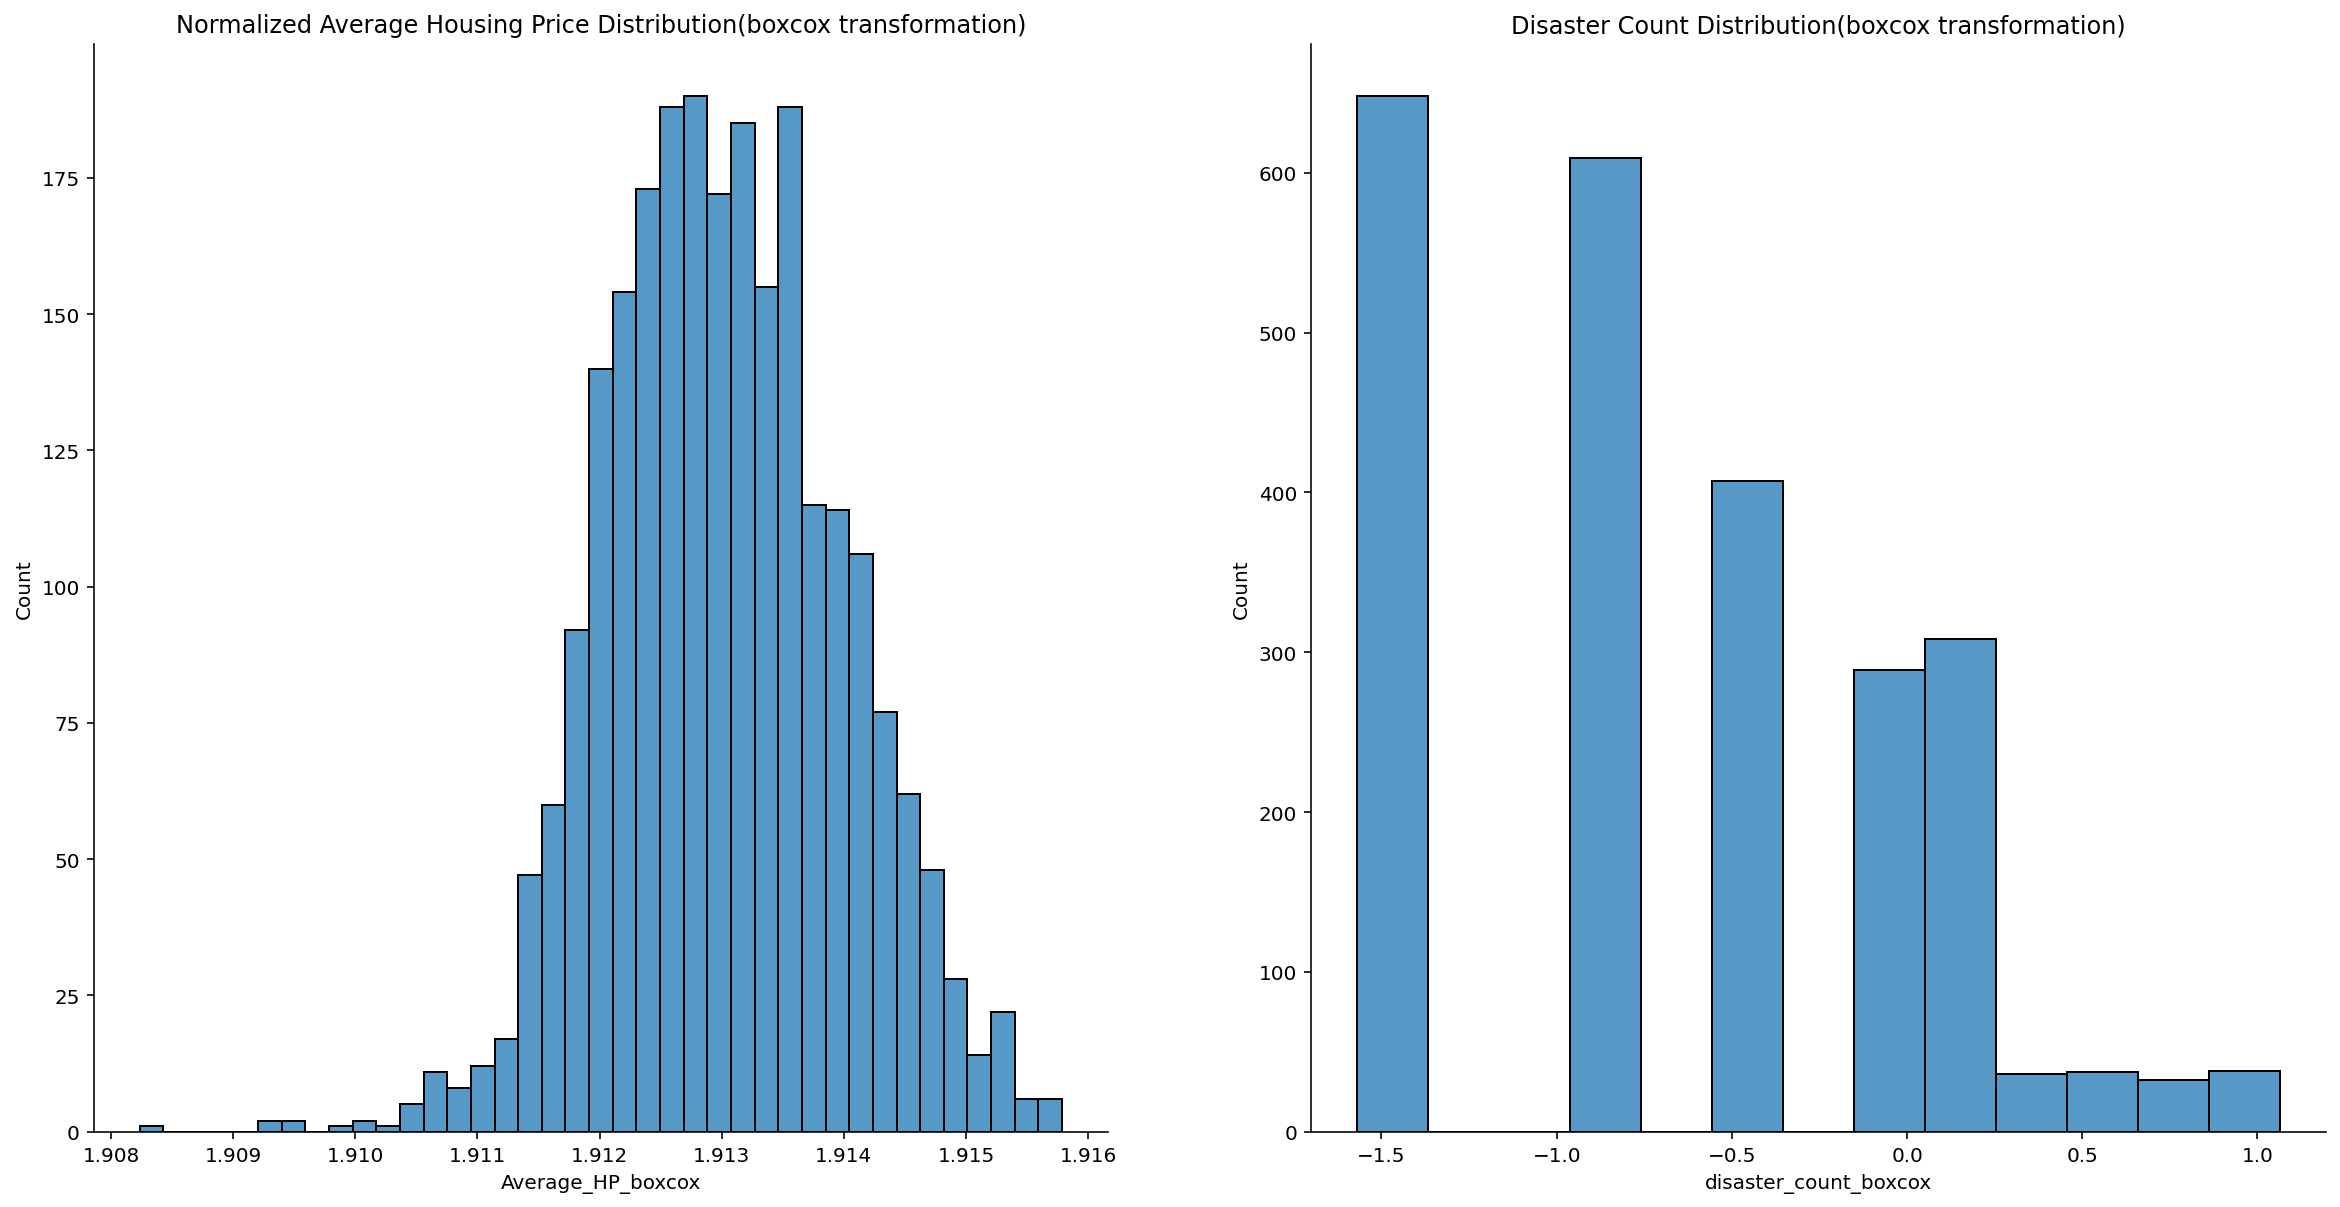

In [65]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

sns.histplot(x='Average_HP_boxcox', data = merged_df, ax=ax1).set_title('Normalized Average Housing Price Distribution(boxcox transformation)')

sns.despine()

sns.histplot(x='disaster_count_boxcox', data = merged_df, ax=ax2).set_title('Disaster Count Distribution(boxcox transformation)')

sns.despine()

plt.show()

<AxesSubplot:xlabel='disaster_count_boxcox', ylabel='Average_HP_boxcox'>

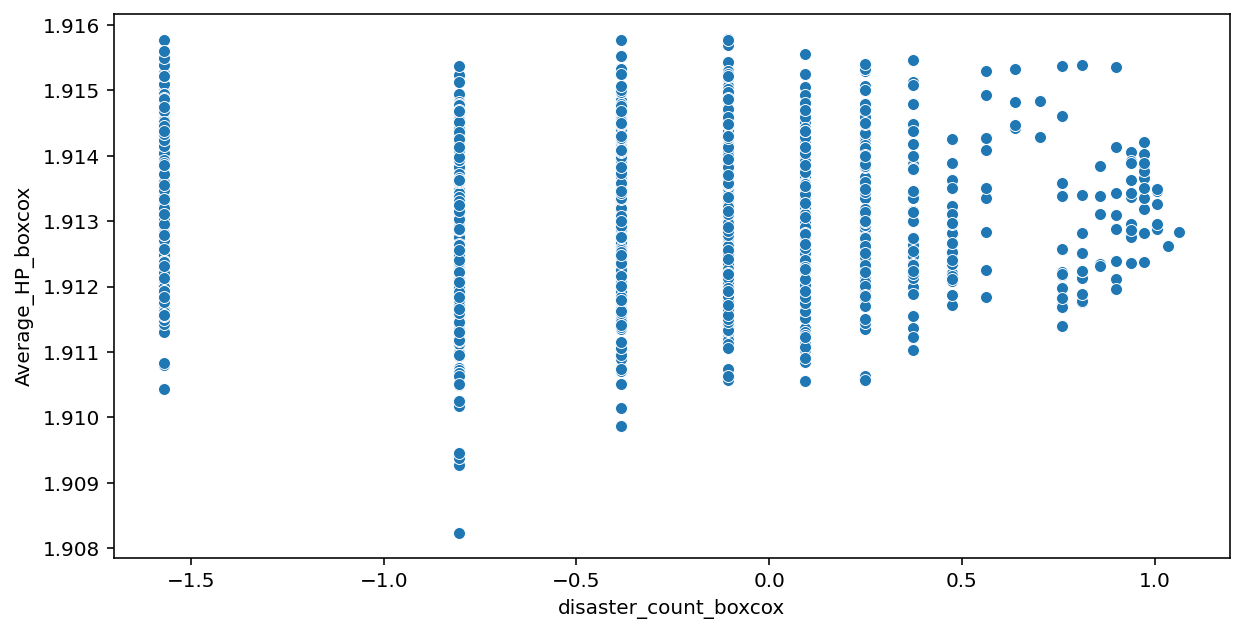

In [66]:
#A lined scatter plot for disaster count vs Average_HP 
sns.scatterplot(x = 'disaster_count_boxcox',y='Average_HP_boxcox',data=merged_df)

# sns.lmplot(x = 'disaster_count_boxcox', y = 'Average_HP_boxcox', height = 6, aspect=1.5,data = merged_df)

# plt.title('LinePlot of disaster_count vs. Average_Housing_Price')

# plt.show()

In [67]:
outcome, predictors = patsy.dmatrices('Average_HP_boxcox ~ disaster_count_boxcox', merged_df)

mod_log = sm.OLS(outcome, predictors)
res_log = mod_log.fit()
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:      Average_HP_boxcox   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.162
Date:                Sun, 13 Mar 2022   Prob (F-statistic):             0.0755
Time:                        09:49:01   Log-Likelihood:                 13295.
No. Observations:                2404   AIC:                        -2.659e+04
Df Residuals:                    2402   BIC:                        -2.657e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.91

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

*Specify who in your group worked on which parts of the project.*